##### Copyright 2018 The TensorFlow Authors.



In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np
import os
import time
from PIL import Image
import pandas as pd
from sklearn.utils import shuffle

     |████████████████████████████████| 332.1MB 57kB/s 
     |████████████████████████████████| 3.0MB 37.8MB/s 
     |████████████████████████████████| 419kB 57.9MB/s 
     |████████████████████████████████| 61kB 23.6MB/s 


In [0]:
!ls

sample_data


### Mount google drive with dataset


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
drive_path = '/content/gdrive/My Drive/SSL/'
!ls '{drive_path}'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
train.csv  train.zip  val.csv  val.zip


### Paths to important files and directories

In [0]:
drive_path_to_train_csv = 'train.csv'
drive_path_to_val_csv = 'val.csv'
drive_path_to_train_zip = 'train.zip'
drive_path_to_val_zip = 'val.zip'

train_csv_filepath = drive_path + drive_path_to_train_csv
val_csv_filepath = drive_path + drive_path_to_val_csv
train_zip_filepath = drive_path + drive_path_to_train_zip
val_zip_filepath = drive_path + drive_path_to_val_zip
train_set_dir = './train/'
val_set_dir = './val/'

### Unzip the datasets if they have not been unzipped

In [0]:
if not os.path.exists(val_set_dir):
  !time  unzip -q '{val_zip_filepath}' 


real	0m5.116s
user	0m2.110s
sys	0m1.090s


In [0]:
if not os.path.exists(train_set_dir):
  !time  unzip -q '{train_zip_filepath}'

file #1:  bad zipfile offset (lseek):  0
file #2:  bad zipfile offset (local header sig):  36
file #3:  bad zipfile offset (lseek):  16384
file #4:  bad zipfile offset (lseek):  32768
file #5:  bad zipfile offset (lseek):  57344


### Load csv files with with image ids and captions. Limit the dataset for faster training when testing.

In [0]:
num_train_examples = 30000
train_df = pd.read_csv(train_csv_filepath)[:num_train_examples]
val_df = pd.read_csv(val_csv_filepath)[:128]

train_df[:2]

### Determine paths for images and add start/end tokens to captions for both datasets. Shuffle training set.

In [0]:
def collect_paths_captions(df, set_dir):
  all_captions = []
  all_img_paths = []
  for index, row in df.iterrows():
    caption = '<start> ' + row['caption'] + ' <end>'
    image_id = row['image_id']
    full_image_path = set_dir + str(image_id) + '.jpg'
    all_img_paths.append(full_image_path)
    all_captions.append(caption)
  return all_captions, all_img_paths

train_captions, train_paths = collect_paths_captions(train_df, train_set_dir)
val_captions, val_paths = collect_paths_captions(val_df, val_set_dir)

# shuffle train data
train_captions, train_paths = shuffle(train_captions, train_paths, 
                                      random_state=1)

print(train_captions[:3], len(train_captions))

## Preprocess and tokenize the captions

* First, we'll tokenize the captions (e.g., by splitting on spaces). This will give us a  vocabulary of all the unique words in the data (e.g., "surfing", "football", etc).
* Next, we'll limit the vocabulary size to the words which appear at least K times. All other words will be replaced with the token "UNK" (for unknown).
* Finally, we create a word --> index mapping and vice-versa.
* We will then pad all sequences to the be same length as the longest one.



In [0]:
min_frequency = 1

tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
top = len([1 for word, count in tokenizer.word_counts.items() if count >= min_frequency]) + 1 # add 1 for <unk>
tokenizer.num_words = top

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
vocabulary_size = top + 1  # added 1 for <pad>

In [0]:
# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
val_seqs = tokenizer.texts_to_sequences(val_captions)

In [0]:
# padding each vector to the max_length of the captions
# if the max_length parameter is not provided, pad_sequences calculates that automatically
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

## Preprocess the images using InceptionV3
Next, we will use InceptionV3 (pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will need to convert the images into the format inceptionV3 expects by:
* Resizing the image to (299, 299)
* Using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to place the pixels in the range of -1 to 1 (to match the format of the images used to train InceptionV3).

In [0]:
IMAGE_SIZE = (299, 299)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

To do so, we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture.
* Each image is forwarded through the network and the vector that we get at the end is stored in a dictionary (image_name --> feature_vector).
* We use the last convolutional layer because we are using attention in this example. The shape of the output of this layer is ```8x8x2048```.
* We avoid doing this during training so it does not become a bottleneck.
* After all the images are passed through the network, we pickle the dictionary and save it to disk.

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but memory intensive, requiring 8 \* 8 \* 2048 floats per image. 

Performance could be improved with a more sophisticated caching strategy (e.g., by sharding the images to reduce random access disk I/O) at the cost of more code.

### Caching option 1: using TFrecords: cache multiple image feature maps into the same file. 
Advantages to numpy save: 
1.   Less random disk access when reading -> faster data loading -> faster training
2.   Can compress files

First setup the cache folder:



In [0]:
train_cache = './train_cache/'
val_cache = './val_cache/'

os.makedirs(train_cache, exist_ok=True)
os.makedirs(val_cache, exist_ok=True)
!ls

In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def serialize_row(feature_map, caption):
  feature = {
# seriaizing as strings is much faster then floats/ints
#       'feature_map': tf.train.Feature(float_list=tf.train.FloatList(value=feature_map.numpy().reshape(-1))),
#       'caption_vector': tf.train.Feature(int64_list=tf.train.Int64List(value=caption.numpy())),
      'feature_map': _bytes_feature(tf.io.serialize_tensor(feature_map).numpy()),
      'caption_vector': _bytes_feature(tf.io.serialize_tensor(caption).numpy())
  }
    
  example = tf.train.Example(features=tf.train.Features(feature=feature))
  return example

# set compression
compression = tf.io.TFRecordCompressionType.NONE
options = tf.io.TFRecordOptions(compression)
def create_fragment_record(features, captions, tfrecord_path):
  with tf.io.TFRecordWriter(tfrecord_path, options=options) as writer:
    for feature, caption in zip(features, captions):
      tf_example = serialize_row(feature, caption)
      writer.write(tf_example.SerializeToString())
    
    
def cache_features(img_paths, captions_vector, cache_folder, batch_size=64, batches_per_file=4):
  start = time.time()
  
  image_ds = tf.data.Dataset.from_tensor_slices(img_paths)
  captions_ds = tf.data.Dataset.from_tensor_slices(captions_vector)

  image_ds = image_ds.map(lambda path: load_image(path)[0], 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = tf.data.Dataset.zip((image_ds, captions_ds))
  ds = ds.batch(batch_size=batch_size, drop_remainder=True)
  
  features = []
  captions = []
  fragment_index = 0
  
  for batch_idx, (image_batch, captions_batch) in enumerate(ds):
    features_batch = image_features_extract_model(image_batch)
    features_batch = tf.reshape(features_batch, (features_batch.shape[0], -1, features_batch.shape[3]))
    
    for feature_map, caption in zip(features_batch, captions_batch):
      features.append(feature_map)
      captions.append(caption)
      
    if (batch_idx + 1) % batches_per_file == 0:
      # write to new file
      cache_file = cache_folder + str(fragment_index) + ".tfrecords"
      create_fragment_record(features, captions, cache_file)
      features = []
      captions = []
      fragment_index += 1
      
  if features:
      cache_file = cache_folder + str(fragment_index) + ".tfrecords"
      create_fragment_record(features, captions, cache_file)
      
  print(f'Caching took: {time.time() - start:.4f} seconds')

In [0]:
cache_features(val_paths, val_cap_vector, val_cache)

In [0]:
cache_features(train_paths, train_cap_vector, train_cache)

### Caching option 2: using numpy save: cache each feature map in separate file.

In [0]:
# def cache_feature_maps(image_dataset):
#   start = time.time()
#   for img, path in image_dataset:
#       batch_features = image_features_extract_model(img)
#       batch_features = tf.reshape(batch_features,
#                                 (batch_features.shape[0], -1, batch_features.shape[3]))

#       for bf, p in zip(batch_features, path):
#           path_of_feature = p.numpy().decode("utf-8")
#           np.save(path_of_feature, bf.numpy())
#   print('Caching took: ', time.time() - start, 'seconds')

In [0]:
# image_ds = tf.data.Dataset.from_tensor_slices(train_paths + val_paths)
# image_ds = image_ds.map(
#   load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
# print('Train + validation set caching...')
# cache_feature_maps(image_ds)

### Compute training sequence max length. Used only at evaluation.

In [0]:
# This will find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# calculating the max_length
# used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing (no need, already have a split in the csv files)


In [0]:
# # Create training and validation sets using 80-20 split
# img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
#                                                                     cap_vector,
#                                                                     test_size=0.2,
#                                                                     random_state=0)

In [0]:
# len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

## Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.



In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
embedding_dim = 256
units = 512
vocab_size = tokenizer.num_words
# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64

### 1) Loading dataset cached with option 1.

In [0]:
from pathlib import Path
tfrecords = [str(path) for path in Path(train_cache).glob("*.tfrecords")]
raw_image_dataset = tf.data.TFRecordDataset(tfrecords, compression_type='')
raw_image_dataset = raw_image_dataset.shuffle(len(tfrecords))

In [0]:
# Create a dictionary describing the features.  
image_feature_description = {
    'feature_map': tf.io.FixedLenFeature([], tf.string),
    'caption_vector': tf.io.FixedLenFeature([], tf.string)
}


def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  dict_features = tf.io.parse_single_example(example_proto, image_feature_description)
  
  feature_map = tf.io.parse_tensor(dict_features['feature_map'], out_type=tf.float32)
  caption = tf.io.parse_tensor(dict_features['caption_vector'], out_type=tf.int32)

  return feature_map, caption

dataset = raw_image_dataset.map(_parse_image_function)
dataset

for i, record in enumerate(dataset.take(3)):
  print(i, repr(record[0].shape), repr(record[1].shape))

0 TensorShape([64, 2048]) TensorShape([59])
1 TensorShape([64, 2048]) TensorShape([59])
2 TensorShape([64, 2048]) TensorShape([59])


In [0]:
# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for i, record in enumerate(dataset.take(3)):
  print(i, repr(record[0].shape), repr(record[1].shape))

0 TensorShape([64, 64, 2048]) TensorShape([64, 59])
1 TensorShape([64, 64, 2048]) TensorShape([64, 59])
2 TensorShape([64, 64, 2048]) TensorShape([64, 59])


### 2) Loading dataset cached with option 2.

In [0]:
# # loading the numpy files
# def map_func(img_path, cap):
#     img_tensor = np.load(img_path.decode('utf-8') + '.npy')
#     return img_tensor, cap

In [0]:
# dataset = tf.data.Dataset.from_tensor_slices((train_paths, cap_vector))

# # using map to load the numpy files in parallel
# dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#           map_func, [item1, item2], [tf.float32, tf.int32]),
#           num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Model

Fun fact, the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, we extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* We squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder(which consists of a single Fully connected layer).
* The RNN(here GRU) attends over the image to predict the next word.

In [0]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training

* We extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
EPOCHS = 30

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    num_steps = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        num_steps += 1
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 3 Batch 0 Loss 1.7540
Epoch 3 Batch 100 Loss 1.2457
Epoch 3 Batch 200 Loss 1.0136
Epoch 3 Batch 300 Loss 1.0090
Epoch 3 Batch 400 Loss 0.9499
Epoch 3 Batch 500 Loss 0.9047
Epoch 3 Batch 600 Loss 0.8695
Epoch 3 Batch 700 Loss 0.9500
Epoch 3 Batch 800 Loss 0.8247
Epoch 3 Batch 900 Loss 0.8699
Epoch 3 Batch 1000 Loss 0.8375
Epoch 3 Batch 1100 Loss 0.7612
Epoch 3 Batch 1200 Loss 0.8218
Epoch 3 Batch 1300 Loss 0.8961
Epoch 3 Batch 1400 Loss 0.7210
Epoch 3 Batch 1500 Loss 0.8743
Epoch 3 Batch 1600 Loss 0.8642
Epoch 3 Batch 1700 Loss 0.7924
Epoch 3 Batch 1800 Loss 0.7678
Epoch 3 Batch 1900 Loss 0.9275
Epoch 3 Batch 2000 Loss 0.8838
Epoch 3 Batch 2100 Loss 0.8741
Epoch 3 Batch 2200 Loss 0.7561
Epoch 3 Batch 2300 Loss 0.8078
Epoch 3 Batch 2400 Loss 0.8245
Epoch 3 Batch 2500 Loss 0.8384
Epoch 3 Batch 2600 Loss 0.7487
Epoch 3 Batch 2700 Loss 0.7347
Epoch 3 Batch 2800 Loss 0.9438
Epoch 3 Batch 2900 Loss 0.8266
Epoch 3 Batch 3000 Loss 0.7261
Epoch 3 Batch 3100 Loss 0.7607
Epoch 3 Loss 0.88184

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [0]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


65536/64400 [==============================] - 0s 0us/step
Prediction Caption: person <unk> the <unk> <end>


ValueError: ignored

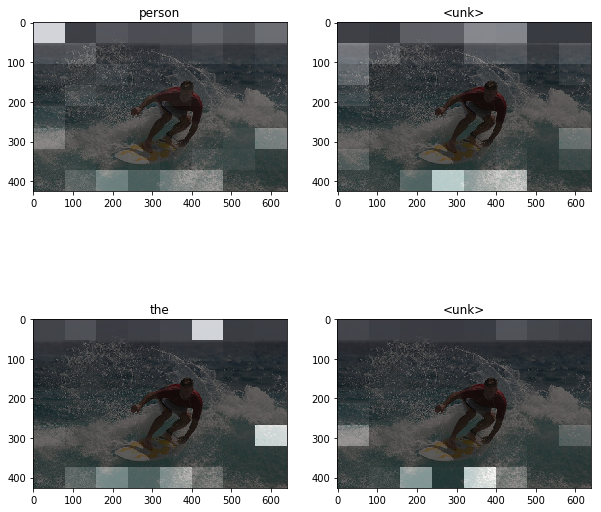

In [0]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
from google.colab import files
def download_ckpt():
    !zip -r ./checkpoints/train.zip ./checkpoints/train
    files.download( "./checkpoints/train.zip" )
    